barn1 - im2.ppm - SLIC Combined Disparity MAE: 0.5991632904949736


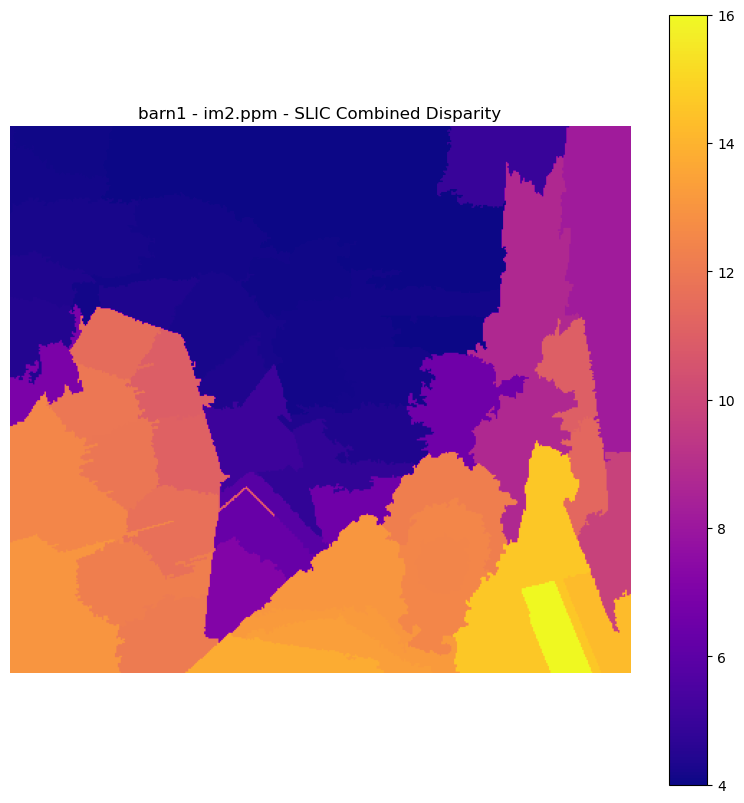

barn1 - im2.ppm - Quickshift Combined Disparity MAE: 0.04039834598053313


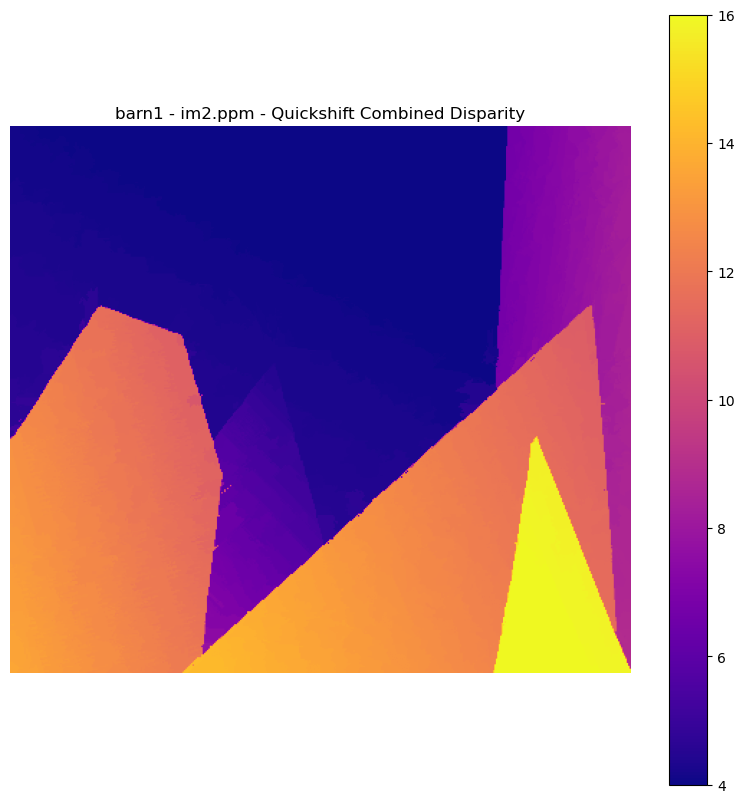

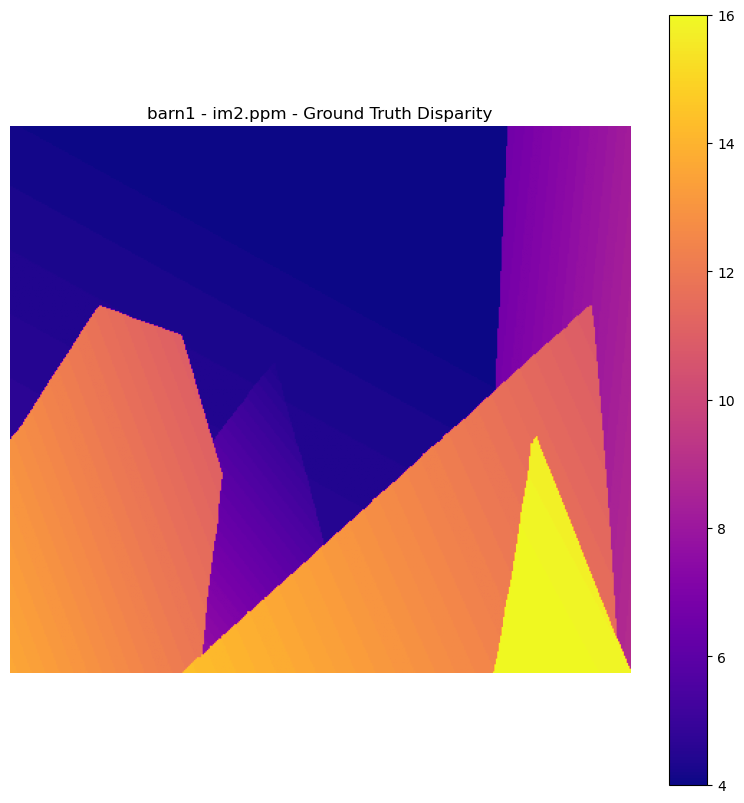

barn1 - im6.ppm - SLIC Combined Disparity MAE: 0.5706640699706094


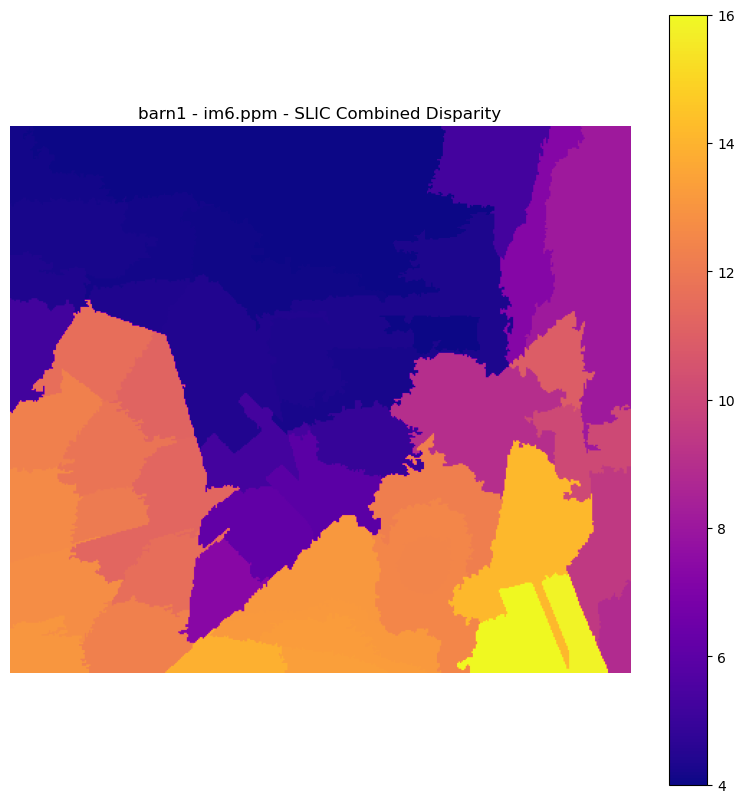

barn1 - im6.ppm - Quickshift Combined Disparity MAE: 0.04149513903369903


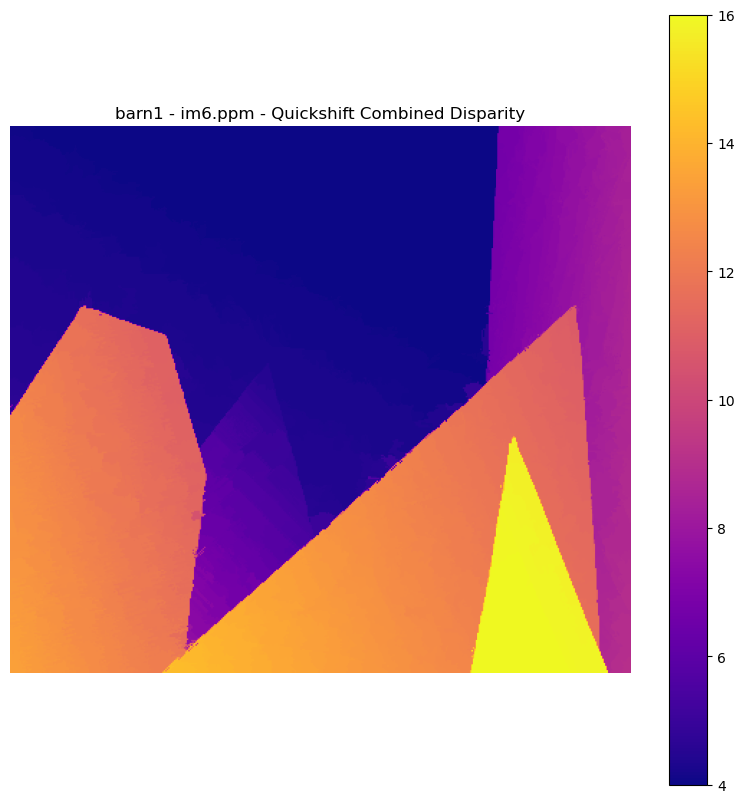

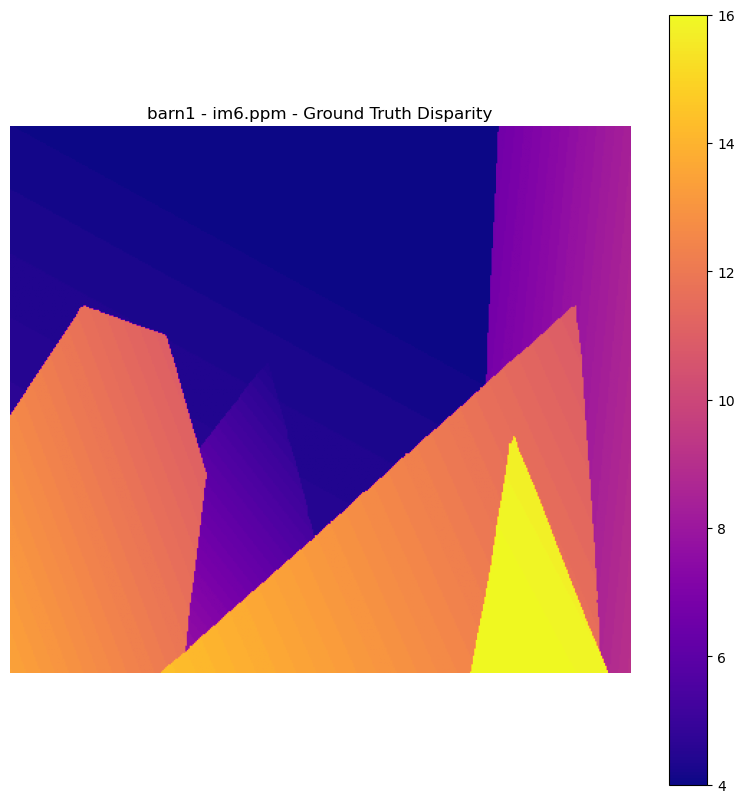

barn2 - im2.ppm - SLIC Combined Disparity MAE: 0.39767328788414696


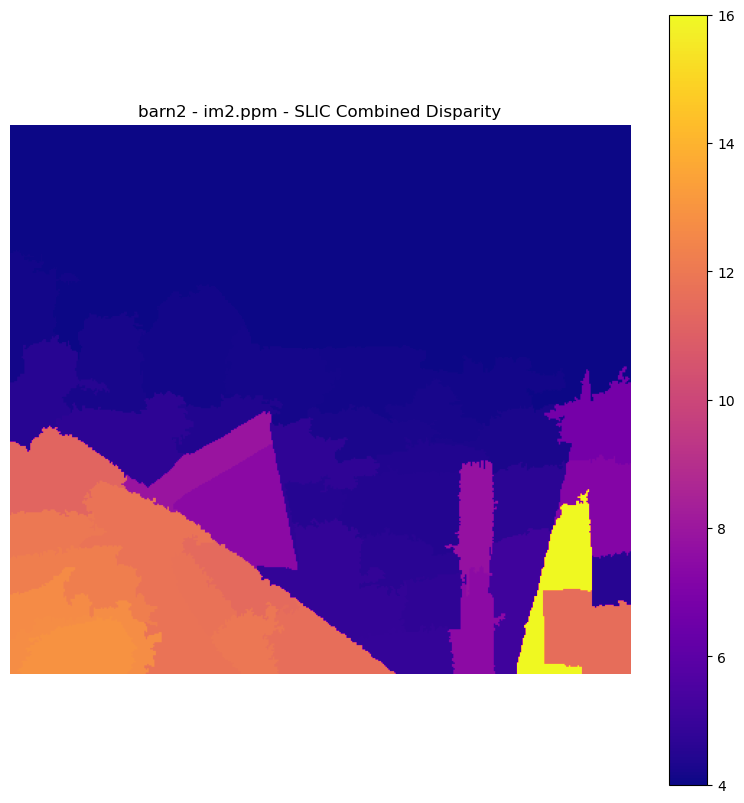

barn2 - im2.ppm - Quickshift Combined Disparity MAE: 0.05696928461914674


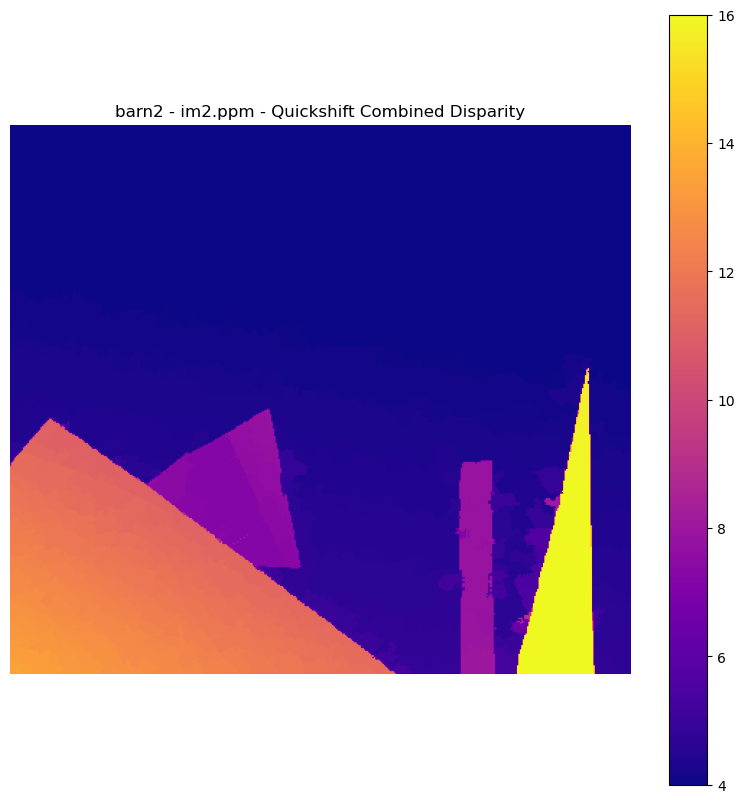

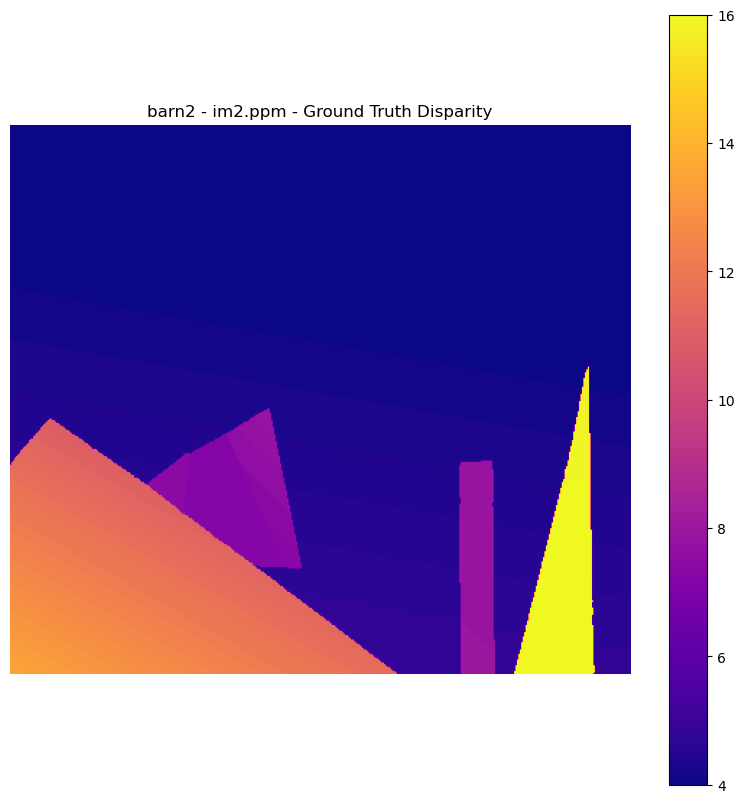

barn2 - im6.ppm - SLIC Combined Disparity MAE: 0.26849883316066747


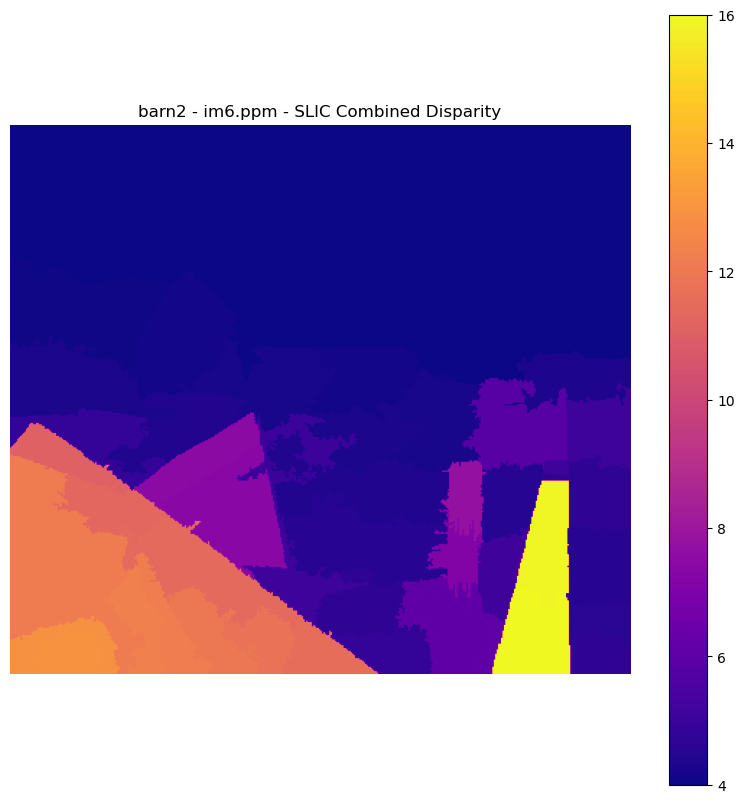

barn2 - im6.ppm - Quickshift Combined Disparity MAE: 0.04626855667120166


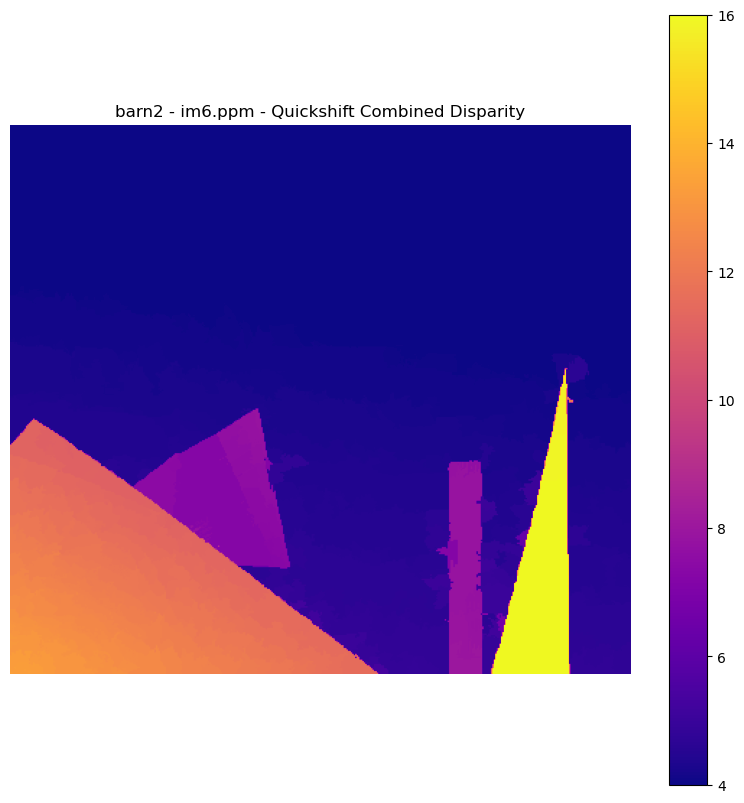

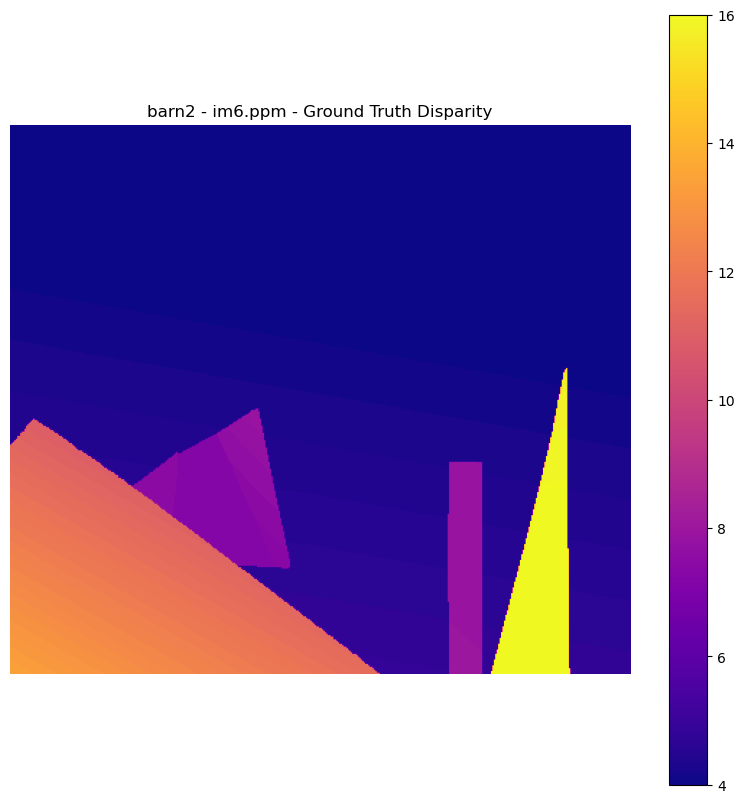

bull - im2.ppm - SLIC Combined Disparity MAE: 0.36071972313356115


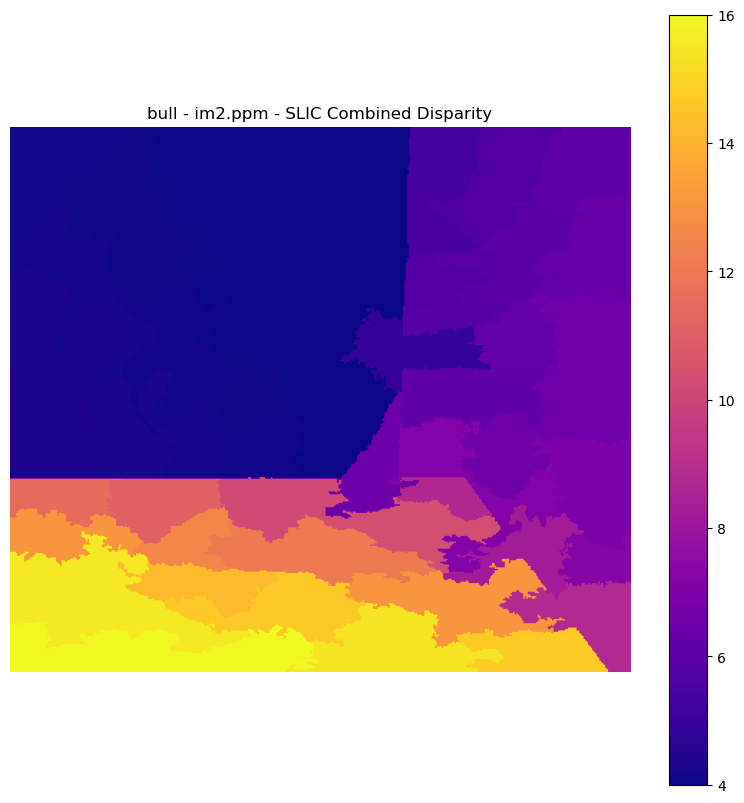

bull - im2.ppm - Quickshift Combined Disparity MAE: 0.05678344325994608


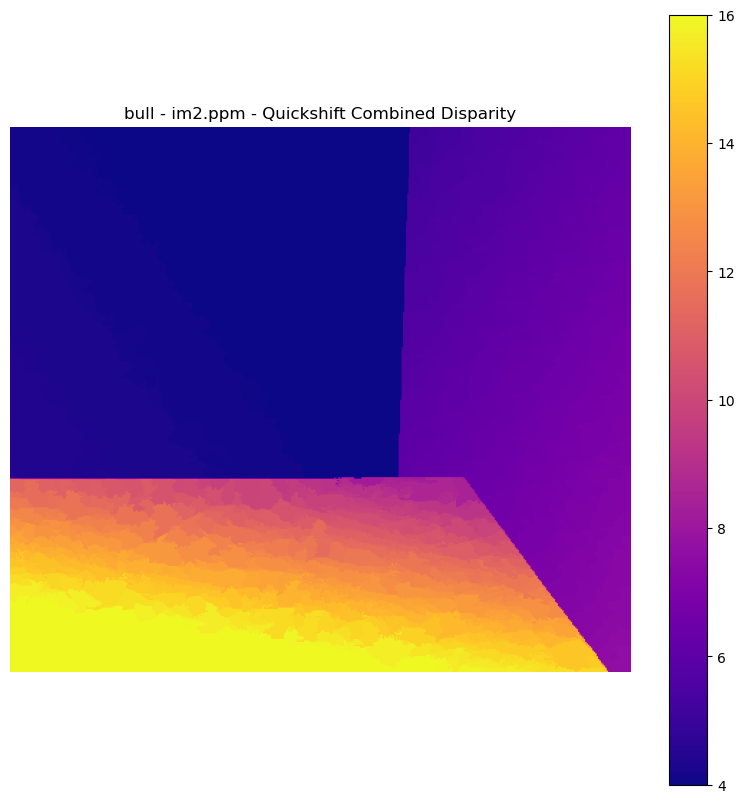

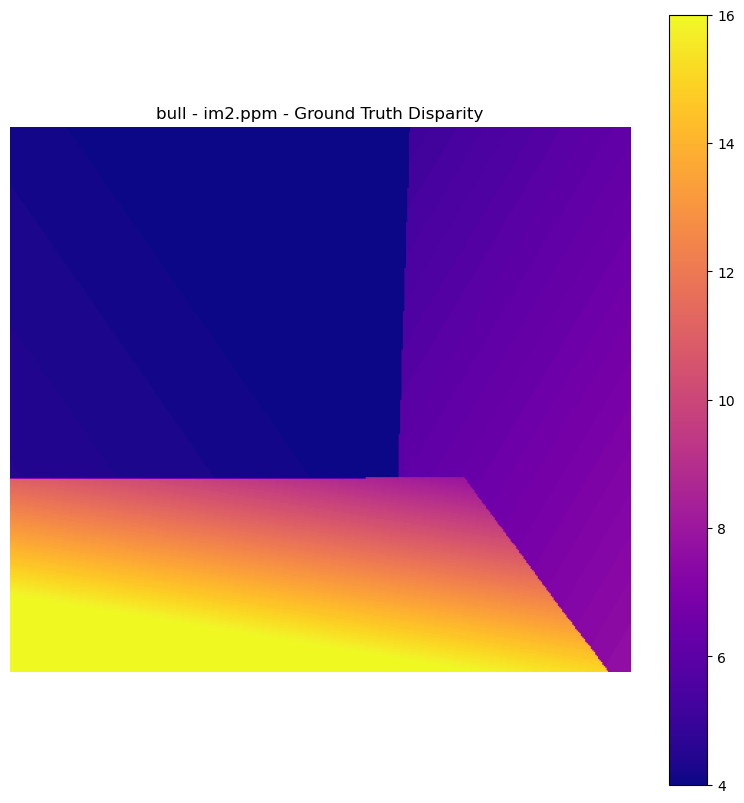

bull - im6.ppm - SLIC Combined Disparity MAE: 0.40873252375730873


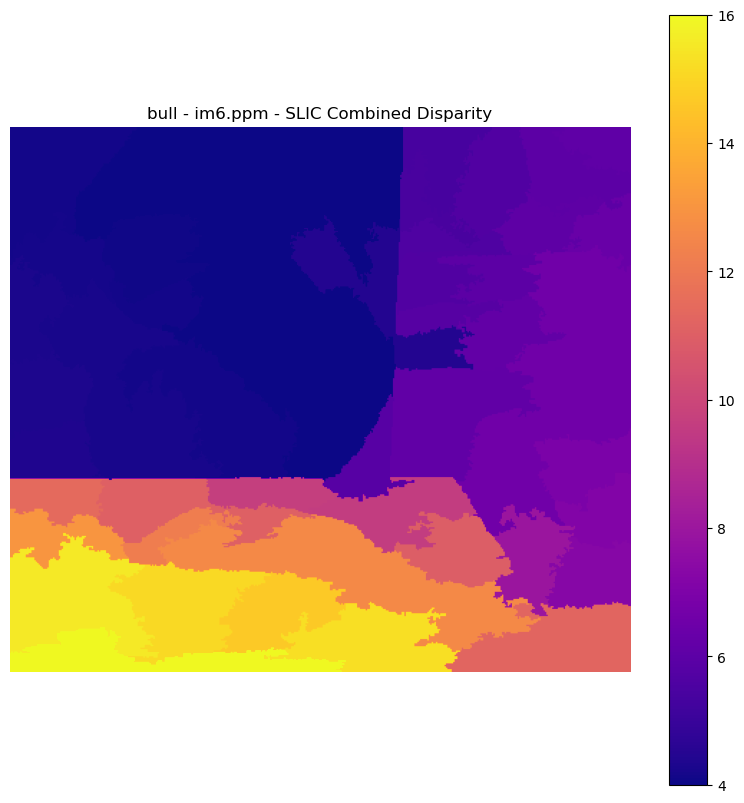

bull - im6.ppm - Quickshift Combined Disparity MAE: 0.055404094821102125


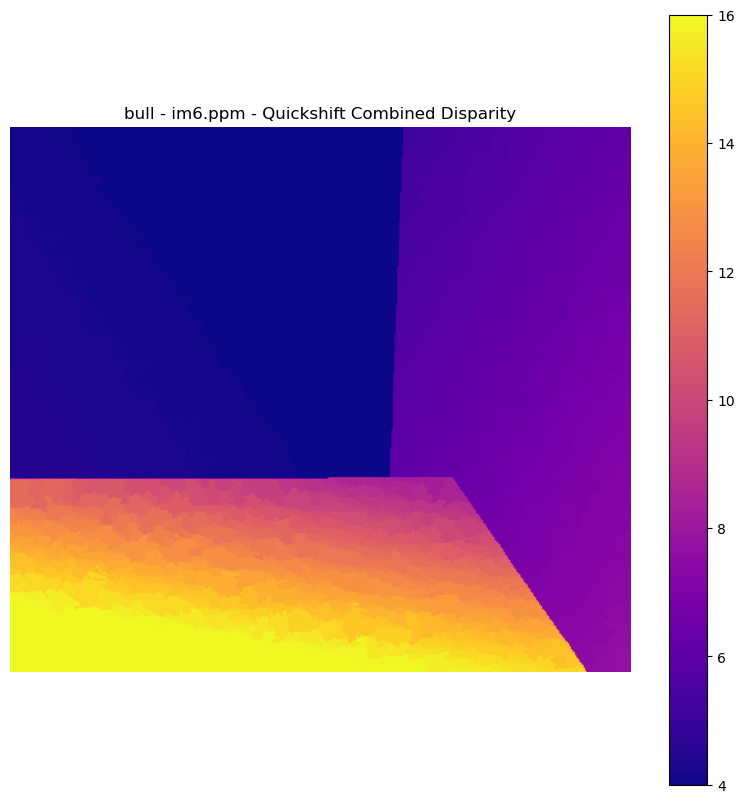

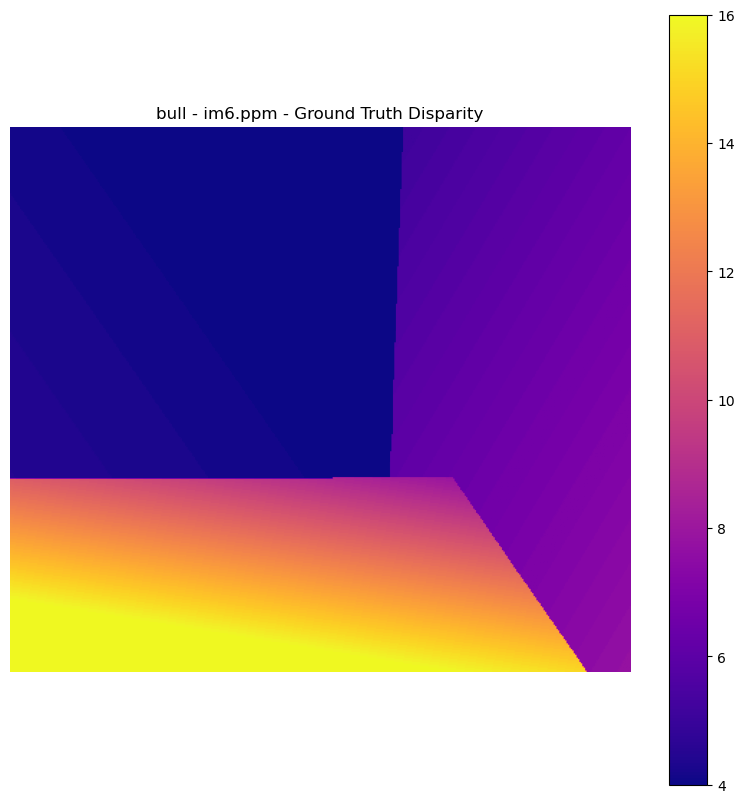

poster - im2.ppm - SLIC Combined Disparity MAE: 0.5107695933855662


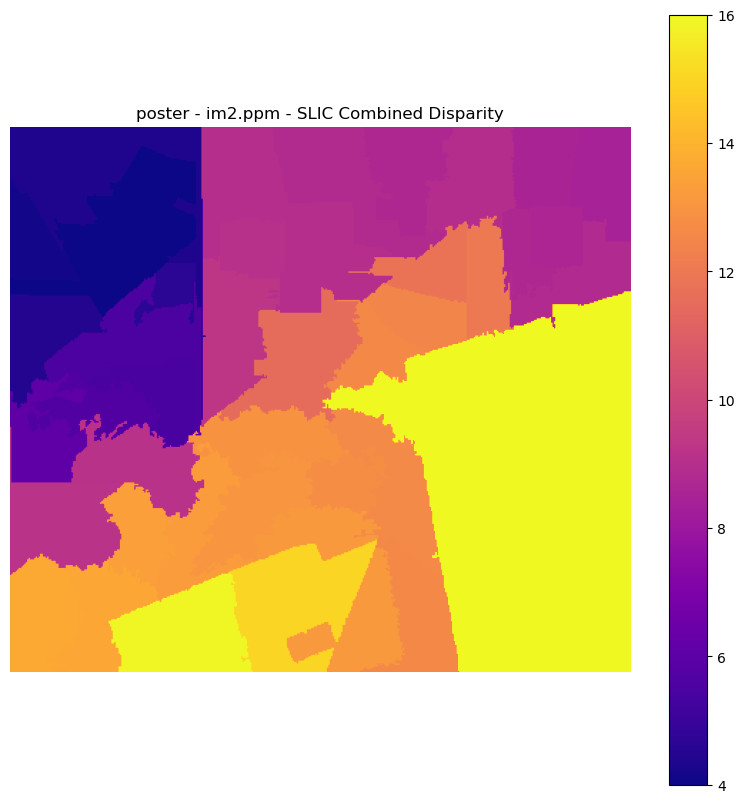

poster - im2.ppm - Quickshift Combined Disparity MAE: 0.033250446065066074


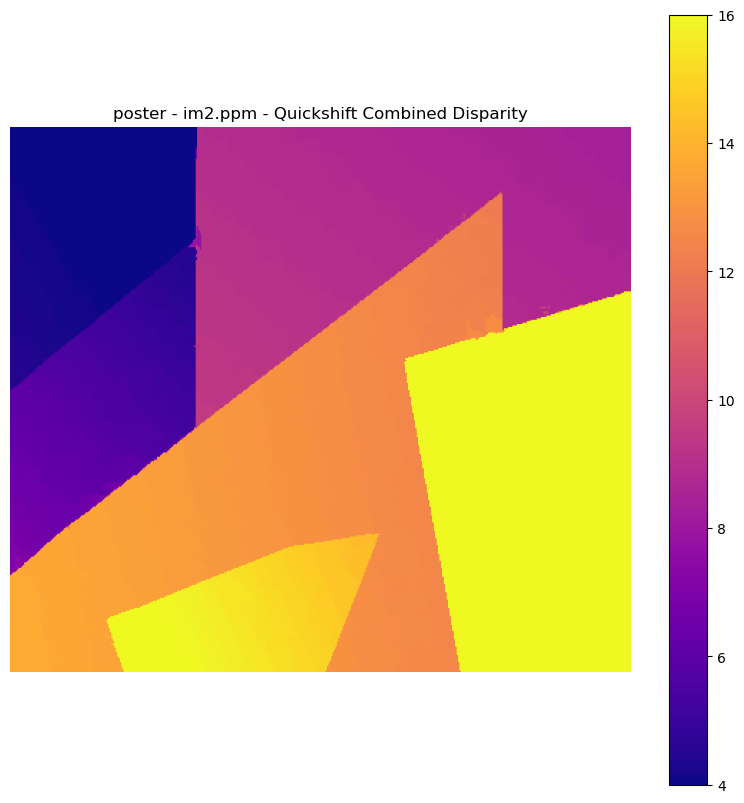

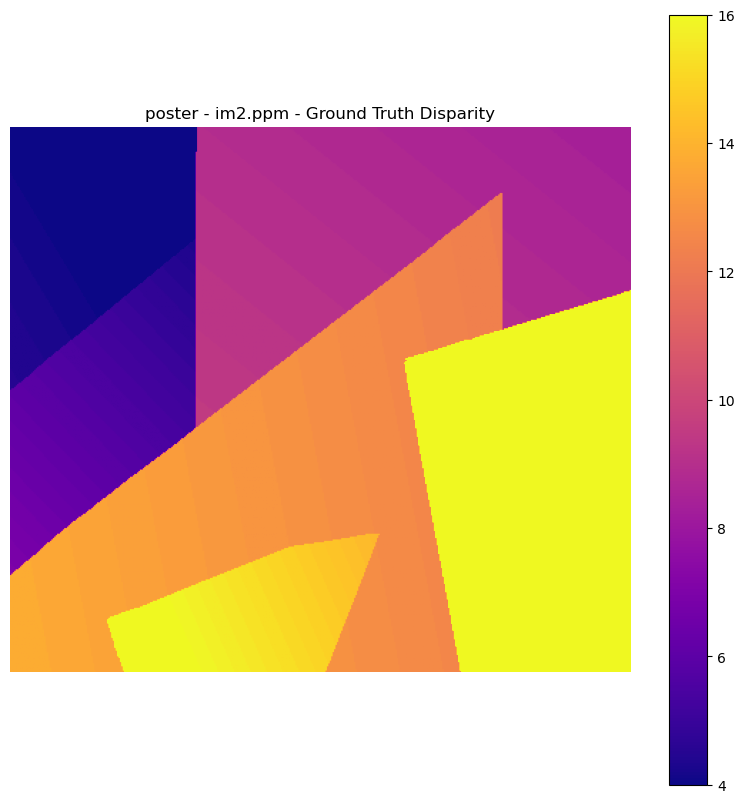

poster - im6.ppm - SLIC Combined Disparity MAE: 0.4953246471434864


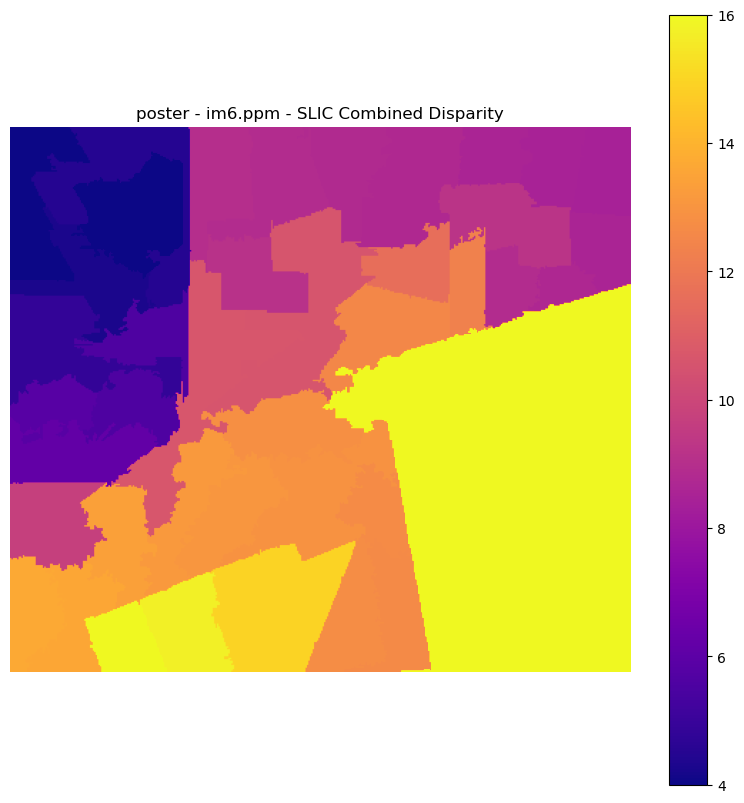

poster - im6.ppm - Quickshift Combined Disparity MAE: 0.038531969494706976


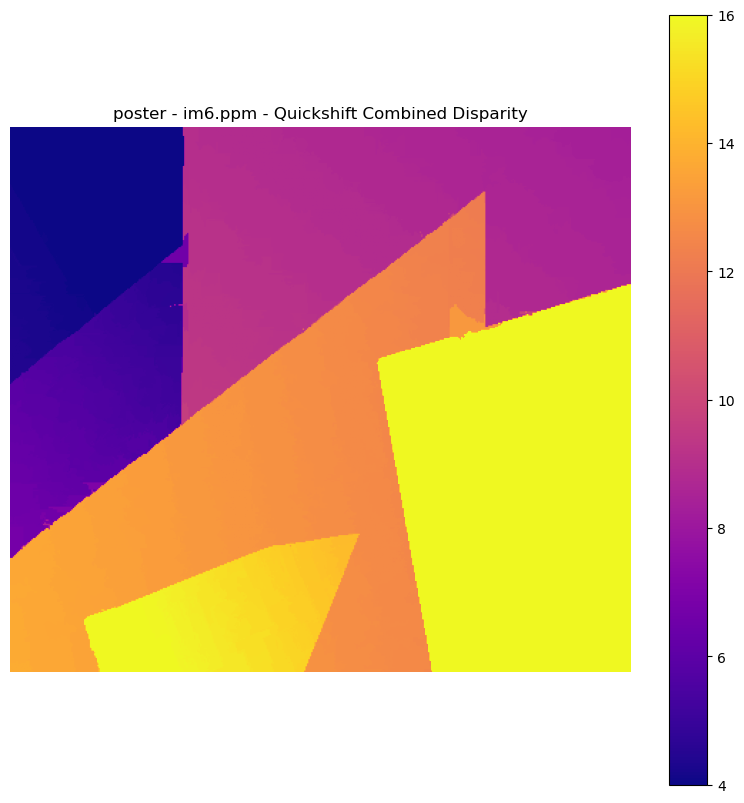

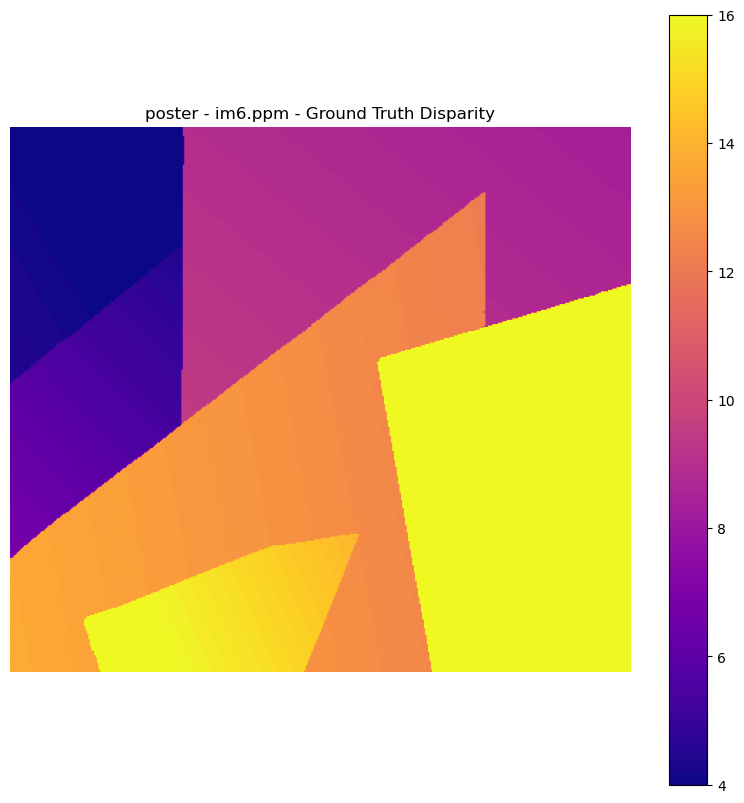

sawtooth - im2.ppm - SLIC Combined Disparity MAE: 0.8569057746668723


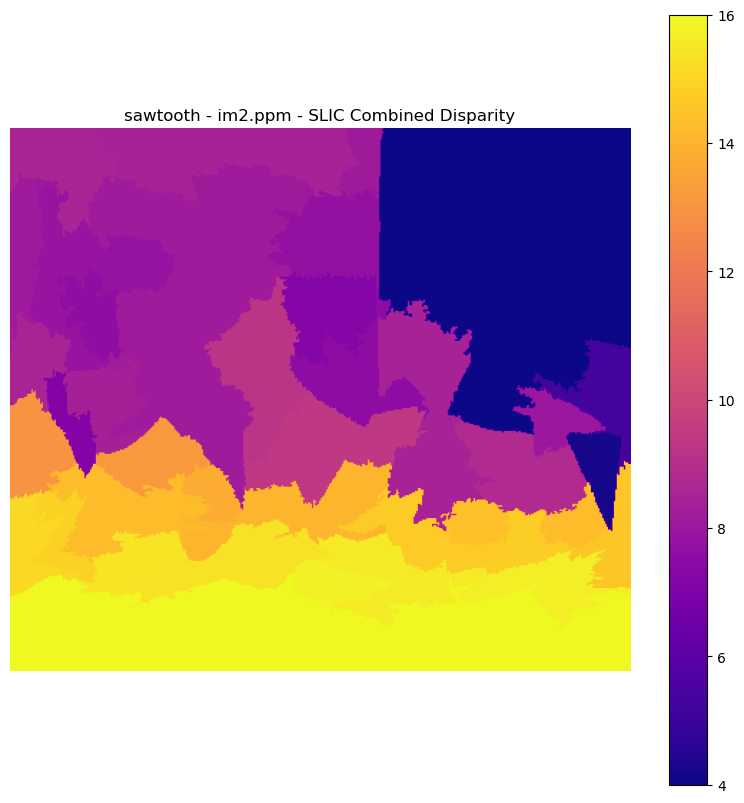

sawtooth - im2.ppm - Quickshift Combined Disparity MAE: 0.06343659921665565


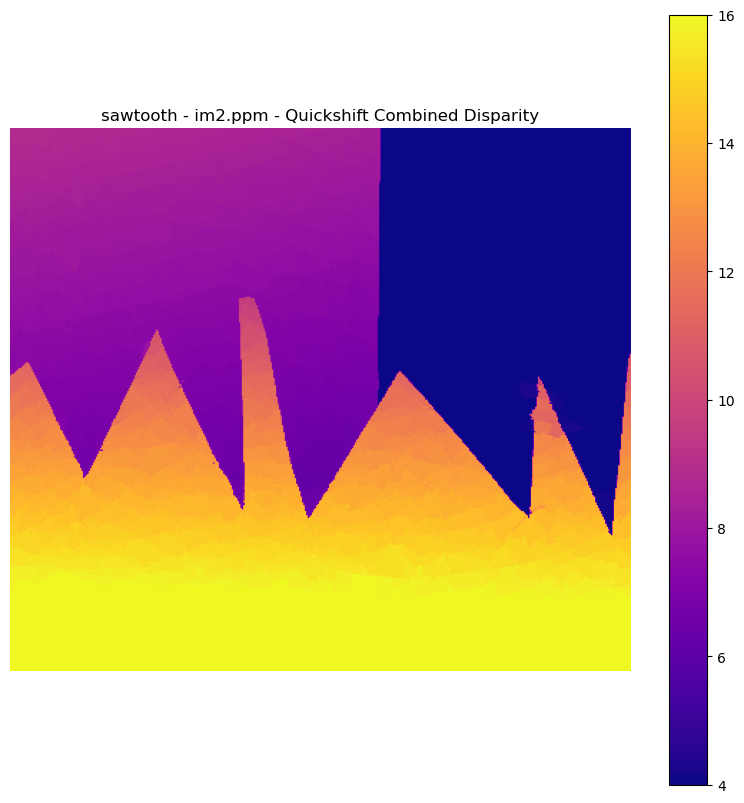

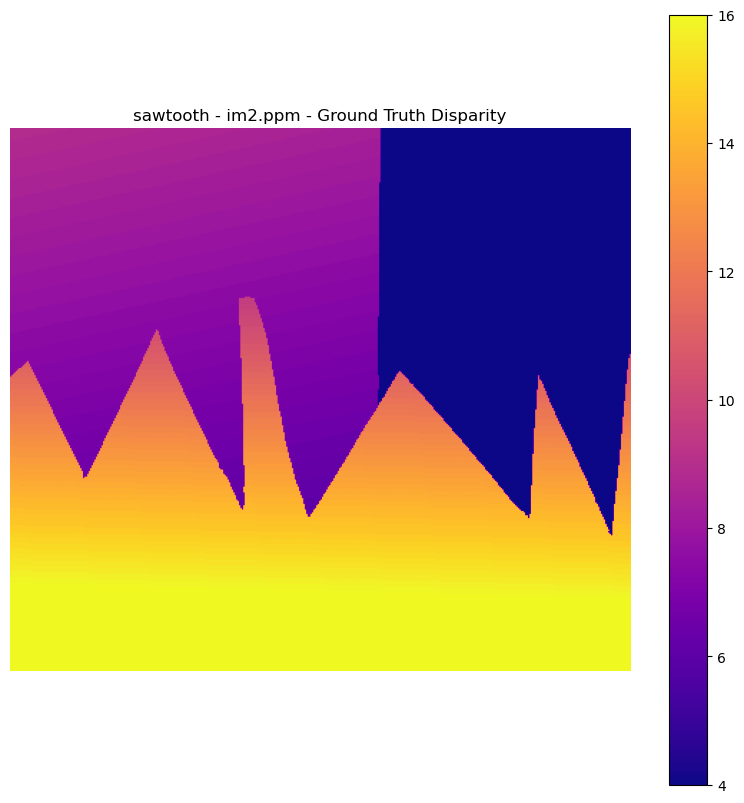

sawtooth - im6.ppm - SLIC Combined Disparity MAE: 0.8236826894825187


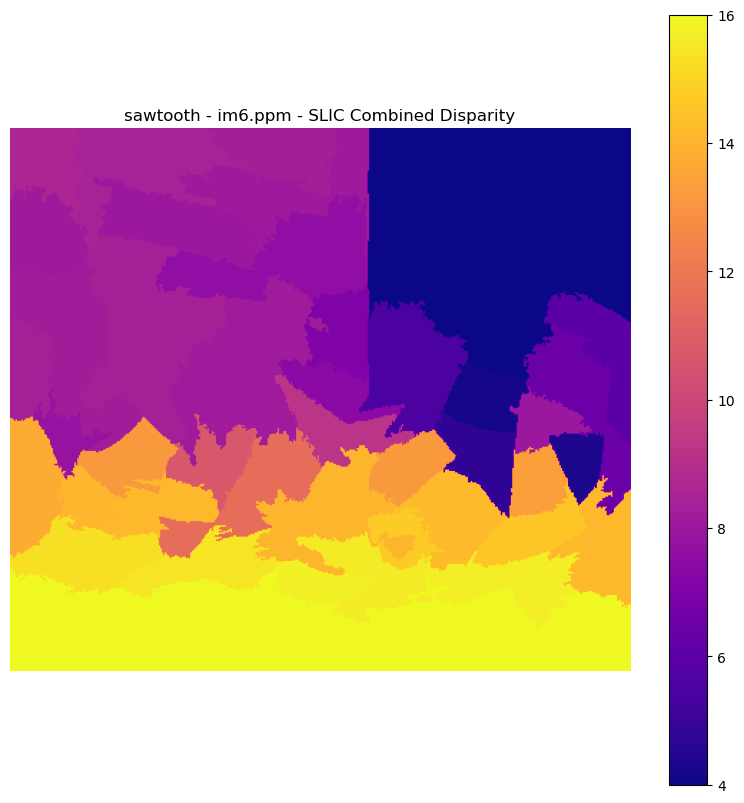

sawtooth - im6.ppm - Quickshift Combined Disparity MAE: 0.061212733850768974


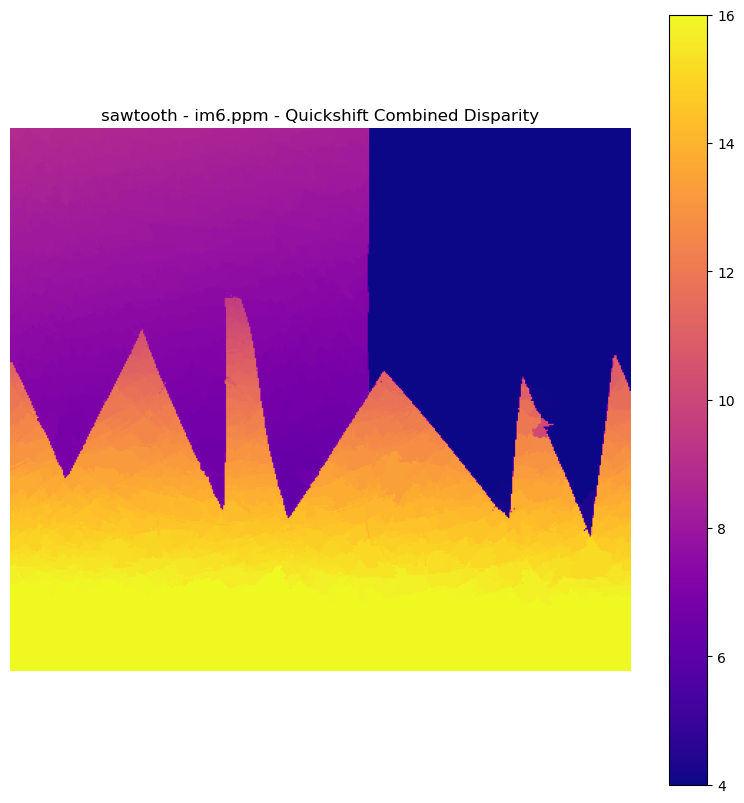

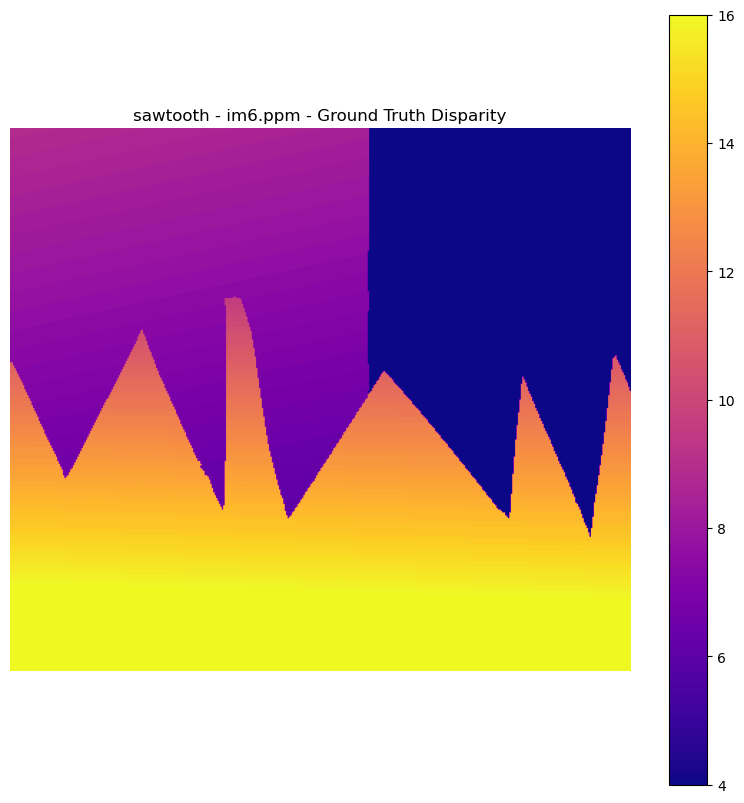

venus - im2.ppm - SLIC Combined Disparity MAE: 0.3990889474441844


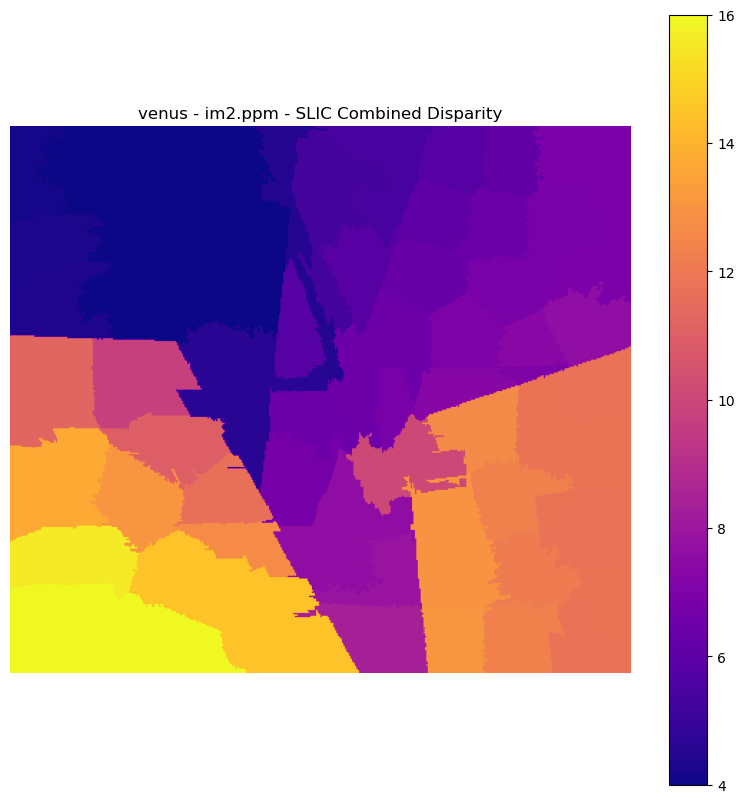

venus - im2.ppm - Quickshift Combined Disparity MAE: 0.07627368916419762


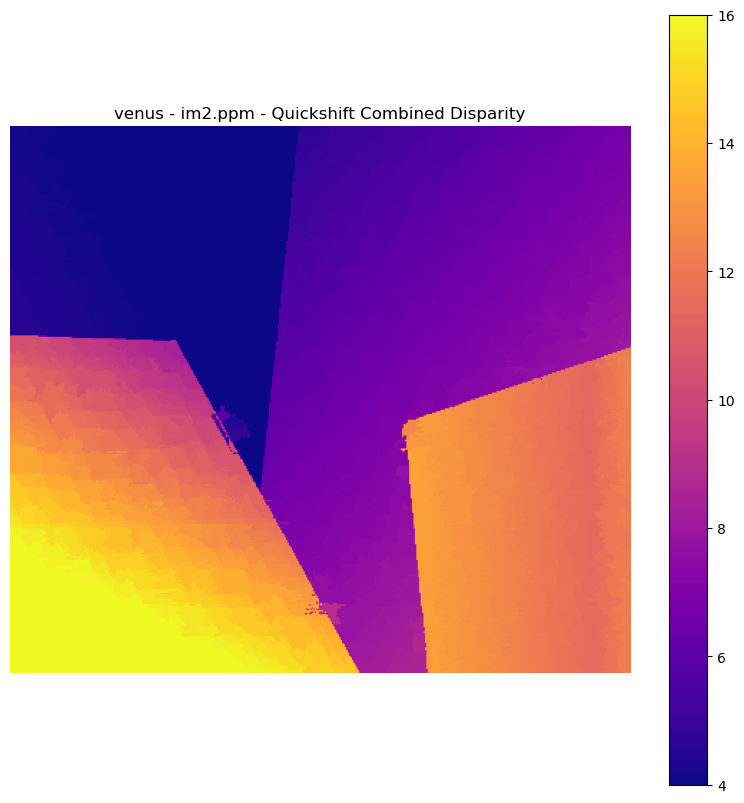

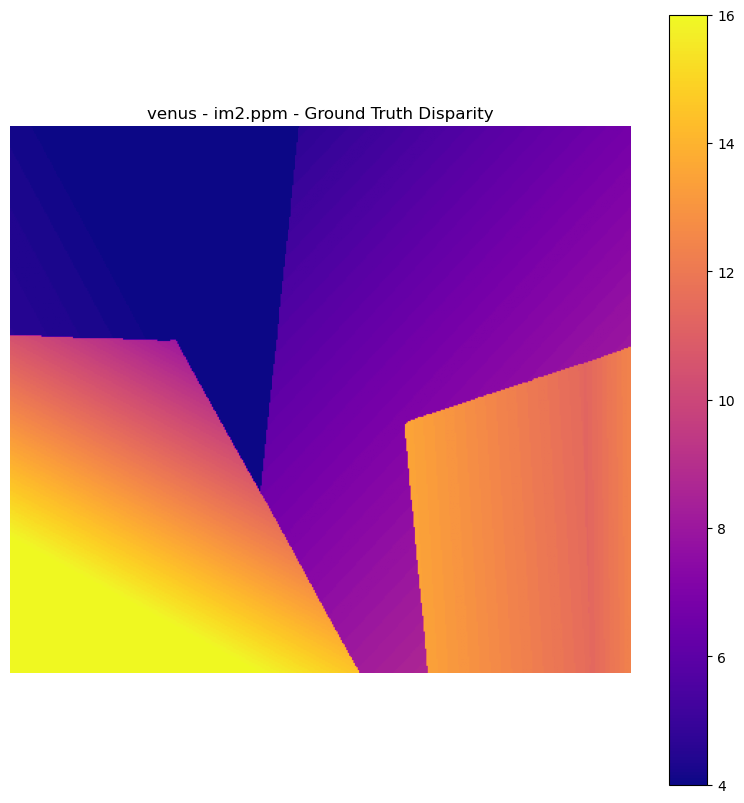

venus - im6.ppm - SLIC Combined Disparity MAE: 0.4422297970765994


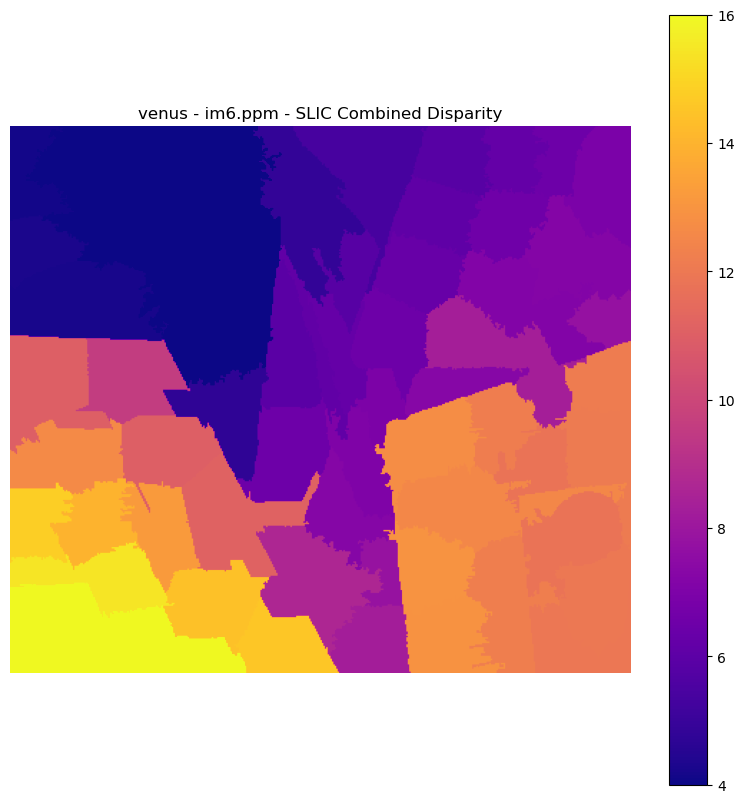

venus - im6.ppm - Quickshift Combined Disparity MAE: 0.07525110370984416


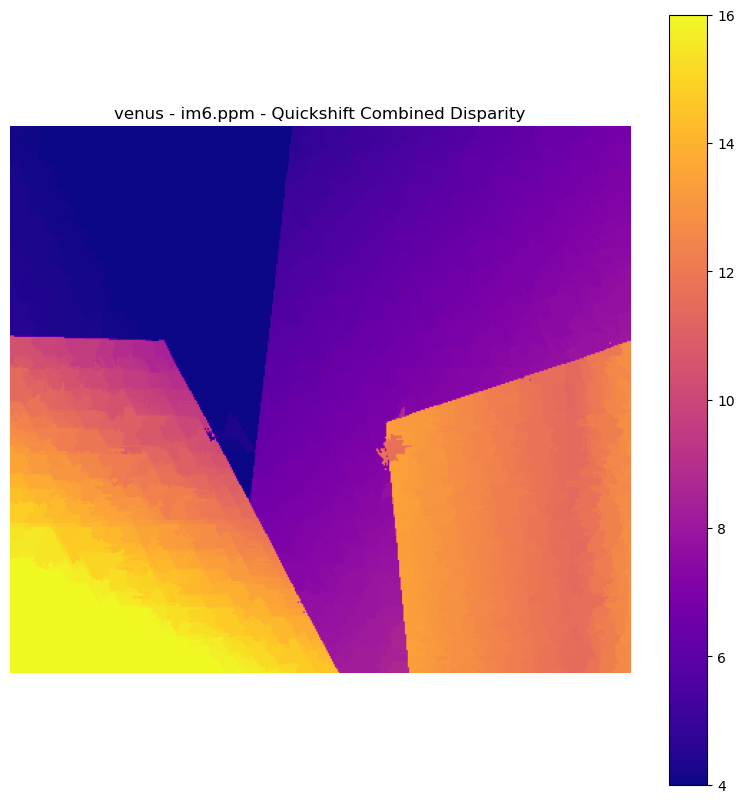

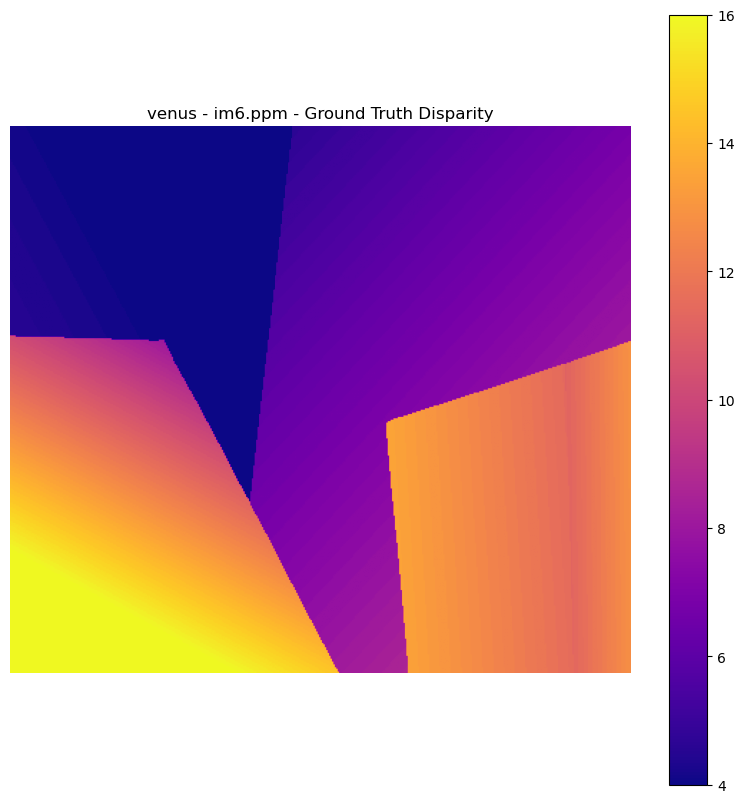

Done


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic, quickshift, mark_boundaries
from skimage.color import rgb2lab
import os

# Function to load an image
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    return image

# Function to display and save images with matplotlib
def save_and_show_image(image, file_path, title='Image', vmin=None, vmax=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='plasma', vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.axis('off')
    plt.colorbar()
    plt.savefig(file_path)
    plt.show()
    plt.close()

# Function to perform SLIC oversegmentation
def oversegment_slic(image, n_segments=100, compactness=10):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_lab = rgb2lab(image_rgb)
    segments = slic(image_lab, n_segments=n_segments, compactness=compactness)
    return segments

# Function to perform Quickshift oversegmentation
def oversegment_quickshift(image, kernel_size=2, max_dist=4, ratio=0.5):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    segments = quickshift(image_rgb, kernel_size=kernel_size, max_dist=max_dist, ratio=ratio)
    return segments

# Function to compute the Sum of Absolute Differences (SAD) between two segments
def compute_sad(segment1, segment2):
    return np.sum(np.abs(segment1 - segment2))

# Function to match segments between left and right images
def match_segments(left_image, right_image, left_segments, right_segments):
    matches = []
    # Calculate mean color and row for each segment in the left image
    left_segment_means = {
        i: (cv2.mean(left_image, mask=(left_segments == i).astype(np.uint8))[:3], np.mean(np.where(left_segments == i)[0]))
        for i in np.unique(left_segments)
    }
    # Calculate mean color and row for each segment in the right image
    right_segment_means = {
        j: (cv2.mean(right_image, mask=(right_segments == j).astype(np.uint8))[:3], np.mean(np.where(right_segments == j)[0]))
        for j in np.unique(right_segments)
    }
    
    # Match segments between left and right images based on color similarity and row alignment
    for i, (left_mean, left_row) in left_segment_means.items():
        best_match = None
        best_sad = float('inf')
        for j, (right_mean, right_row) in right_segment_means.items():
            if abs(left_row - right_row) < 5:  # Ensure the match is on the epipolar line (or close to it)
                sad = np.sum(np.abs(np.array(left_mean) - np.array(right_mean)))  # Calculate SAD
                if sad < best_sad:
                    best_sad = sad
                    best_match = j
        if best_match is not None:
            matches.append((i, best_match))
    return matches

# Function to load a disparity map and scale it
def load_disparity_map(disp_path, scale_factor=8):
    disparity_map = cv2.imread(disp_path, cv2.IMREAD_UNCHANGED)
    if disparity_map is None:
        raise FileNotFoundError(f"Disparity map not found: {disp_path}")
    return disparity_map / scale_factor

# Function to compute the Mean Absolute Error (MAE) between estimated and ground truth disparity
def compute_disparity_error(matches, left_segments, right_segments, ground_truth):
    estimated_disparity = np.zeros_like(ground_truth, dtype=float)
    for left_seg, right_seg in matches:
        left_mask = (left_segments == left_seg)
        right_mask = (right_segments == right_seg)
        disp_value = np.mean(ground_truth[left_mask])
        estimated_disparity[left_mask] = disp_value
    error = np.abs(estimated_disparity - ground_truth)
    mae = np.mean(error)
    return mae

# Paths to datasets
datasets = ['barn1', 'barn2', 'bull', 'poster', 'sawtooth', 'venus']
base_path = 'datasets'

# Define the ground-truth disparity maps
disparity_maps = {
    'im2.ppm': 'disp2.pgm',
    'im6.ppm': 'disp6.pgm'
}

# Directory to save results
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)

# File to save MAE results
results_file = os.path.join(output_dir, 'mae_results.txt')
with open(results_file, 'w') as f:
    # Process each dataset
    for dataset in datasets:
        dataset_path = os.path.join(base_path, dataset)
        
        for left_image_file, disparity_map_file in disparity_maps.items():
            left_image_path = os.path.join(dataset_path, left_image_file)
            ground_truth_path = os.path.join(dataset_path, disparity_map_file)
            
            # Load the left image and ground-truth disparity map
            left_image = load_image(left_image_path)
            ground_truth = load_disparity_map(ground_truth_path)
            
            # Initialize the combined disparity map with zeros
            combined_disparity_slic = np.zeros_like(ground_truth, dtype=float)
            combined_disparity_quickshift = np.zeros_like(ground_truth, dtype=float)
            count_map_slic = np.zeros_like(ground_truth, dtype=float)
            count_map_quickshift = np.zeros_like(ground_truth, dtype=float)
            
            for i in range(9):
                if f'im{i}.ppm' != left_image_file:
                    right_image_path = os.path.join(dataset_path, f'im{i}.ppm')
                    right_image = load_image(right_image_path)

                    # Apply SLIC segmentation
                    left_segments_slic = oversegment_slic(left_image)
                    right_segments_slic = oversegment_slic(right_image)

                    # Apply Quickshift segmentation
                    left_segments_quickshift = oversegment_quickshift(left_image)
                    right_segments_quickshift = oversegment_quickshift(right_image)

                    # Run correspondence algorithm for SLIC
                    matches_slic = match_segments(left_image, right_image, left_segments_slic, right_segments_slic)
                    
                    # Estimate disparity based on SLIC matches
                    for left_seg, right_seg in matches_slic:
                        left_mask = (left_segments_slic == left_seg)
                        disp_value = np.mean(ground_truth[left_mask])
                        combined_disparity_slic[left_mask] += disp_value
                        count_map_slic[left_mask] += 1

                    # Run correspondence algorithm for Quickshift
                    matches_quickshift = match_segments(left_image, right_image, left_segments_quickshift, right_segments_quickshift)
                    
                    # Estimate disparity based on Quickshift matches
                    for left_seg, right_seg in matches_quickshift:
                        left_mask = (left_segments_quickshift == left_seg)
                        disp_value = np.mean(ground_truth[left_mask])
                        combined_disparity_quickshift[left_mask] += disp_value
                        count_map_quickshift[left_mask] += 1

            # Compute the average disparity by dividing by the count map
            average_disparity_slic = combined_disparity_slic / count_map_slic
            average_disparity_quickshift = combined_disparity_quickshift / count_map_quickshift
            
            # Compute the Mean Absolute Error (MAE) for SLIC
            mae_slic = np.mean(np.abs(average_disparity_slic - ground_truth))
            print(f'{dataset} - {left_image_file} - SLIC Combined Disparity MAE: {mae_slic}')
            f.write(f'{dataset} - {left_image_file} - SLIC Combined Disparity MAE: {mae_slic}\n')

            # Save and show the SLIC results
            slic_result_path = os.path.join(output_dir, f'{dataset}_{left_image_file}_SLIC_disparity.png')
            save_and_show_image(average_disparity_slic, slic_result_path, title=f'{dataset} - {left_image_file} - SLIC Combined Disparity', vmin=4, vmax=16)

            # Compute the Mean Absolute Error (MAE) for Quickshift
            mae_quickshift = np.mean(np.abs(average_disparity_quickshift - ground_truth))
            print(f'{dataset} - {left_image_file} - Quickshift Combined Disparity MAE: {mae_quickshift}')
            f.write(f'{dataset} - {left_image_file} - Quickshift Combined Disparity MAE: {mae_quickshift}\n')

            # Save and show the Quickshift results
            quickshift_result_path = os.path.join(output_dir, f'{dataset}_{left_image_file}_Quickshift_disparity.png')
            save_and_show_image(average_disparity_quickshift, quickshift_result_path, title=f'{dataset} - {left_image_file} - Quickshift Combined Disparity', vmin=4, vmax=16)

            # Save and show the Ground Truth results for comparison
            ground_truth_result_path = os.path.join(output_dir, f'{dataset}_{left_image_file}_ground_truth.png')
            save_and_show_image(ground_truth, ground_truth_result_path, title=f'{dataset} - {left_image_file} - Ground Truth Disparity', vmin=4, vmax=16)

print('Done')
